# Overview

# Business Understanding

# Data Understanding

## Data Preparation

In [3591]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import gmean
import statistics

In [3592]:
conn = sqlite3.Connection('data/im.db')
imdb_df = pd.read_sql("""

SELECT primary_title, runtime_minutes, genres, start_year, movie_id
FROM movie_basics
JOIN movie_ratings
USING(movie_id)

;""",conn)
imdb_df.head()

,primary_title,runtime_minutes,genres,start_year,movie_id
0,Sunghursh,175.0,"Action,Crime,Drama",2013,tt0063540
1,One Day Before the Rainy Season,114.0,"Biography,Drama",2019,tt0066787
2,The Other Side of the Wind,122.0,Drama,2018,tt0069049
3,Sabse Bada Sukh,NaN,"Comedy,Drama",2018,tt0069204
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",2017,tt0100275


In [3593]:
director_df = pd.read_sql("""

SELECT DISTINCT movie_id, person_id, primary_name
FROM directors
JOIN persons
USING(person_id)


;""",conn)
director_df.head()

,movie_id,person_id,primary_name
0,tt0285252,nm0899854,Tony Vitale
1,tt0462036,nm1940585,Bill Haley
2,tt0835418,nm0151540,Jay Chandrasekhar
3,tt0878654,nm0089502,Albert Pyun
4,tt0878654,nm2291498,Joe Baile


In [3594]:
director_movie_df = director_df.merge(imdb_df, on='movie_id', how = 'inner')

In [3595]:
tn_df = pd.read_csv('data/tn.movie_budgets.csv.gz')
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [3596]:
tn_df['movie'] = tn_df['movie'].apply(lambda x: x.lower())

In [3597]:
director_movie_df['primary_title'] = director_movie_df['primary_title'].apply(lambda x: x.lower())

In [3598]:
combined_df = tn_df.merge(director_movie_df, left_on='movie', right_on='primary_title', how = 'inner')

In [3599]:
# length of dataframe is longer than length of tn_df that we merged on meaning there are multiple primary_titles
# that match the movie titles. Essentially duplicated names; movies with same name. We need to figure out how to
# make sure we are using the right ones and we can do that by matching start_year with release date_year. This
# will not be perfect as dups can have the same year potentially but it will greatly reduce this number for us. 
# Also, some movies might have the same name but not be referring to the same movie, for example avatar is not a
# horror movie and doing further research you see there is an older movie also called avatar. 
combined_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,person_id,primary_name,primary_title,runtime_minutes,genres,start_year
0,1,"Dec 18, 2009",avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309,nm3786927,Atsushi Wada,avatar,93.0,Horror,2011
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,nm0551128,Rob Marshall,pirates of the caribbean: on stranger tides,136.0,"Action,Adventure,Fantasy",2011
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702,nm1334526,Simon Kinberg,dark phoenix,113.0,"Action,Adventure,Sci-Fi",2019
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,nm0923736,Joss Whedon,avengers: age of ultron,141.0,"Action,Adventure,Sci-Fi",2015
4,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,nm0751577,Anthony Russo,avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,68,"Jul 6, 2001",cure,"$10,000","$94,596","$94,596",tt1872026,nm0948107,Bill Yip,cure,93.0,Drama,2011
3249,73,"Jan 13, 2012",newlyweds,"$9,000","$4,584","$4,584",tt1880418,nm0122653,Edward Burns,newlyweds,95.0,"Comedy,Drama",2011
3250,78,"Dec 31, 2018",red 11,"$7,000",$0,$0,tt7837402,nm0001675,Robert Rodriguez,red 11,77.0,"Horror,Sci-Fi,Thriller",2019
3251,81,"Sep 29, 2015",a plague so pleasant,"$1,400",$0,$0,tt2107644,nm4766951,Benjamin Roberds,a plague so pleasant,76.0,"Drama,Horror,Thriller",2013


In [3600]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3253 entries, 0 to 3252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3253 non-null   int64  
 1   release_date       3253 non-null   object 
 2   movie              3253 non-null   object 
 3   production_budget  3253 non-null   object 
 4   domestic_gross     3253 non-null   object 
 5   worldwide_gross    3253 non-null   object 
 6   movie_id           3253 non-null   object 
 7   person_id          3253 non-null   object 
 8   primary_name       3253 non-null   object 
 9   primary_title      3253 non-null   object 
 10  runtime_minutes    3118 non-null   float64
 11  genres             3245 non-null   object 
 12  start_year         3253 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 330.5+ KB


In [3601]:
combined_df['release_date'].value_counts()

release_date
Dec 31, 2014    22
Aug 19, 2011    19
Dec 31, 2012    17
Jan 25, 2013    16
Dec 31, 2015    15
                ..
Jan 21, 2011     1
Nov 25, 1992     1
Aug 10, 2011     1
Jun 30, 2015     1
Dec 31, 2018     1
Name: count, Length: 1034, dtype: int64

In [3602]:
combined_df['movie'].value_counts()

movie
home                       24
the gift                   18
brothers                   16
hamlet                     16
wonderland                 14
                           ..
straight outta compton      1
unhinged                    1
florence foster jenkins     1
logan lucky                 1
the perfect guy             1
Name: count, Length: 2175, dtype: int64

In [3603]:
combined_df['genres'].value_counts()

genres
Drama                         364
Documentary                   150
Comedy                        148
Adventure,Animation,Comedy    116
Comedy,Drama                   99
                             ... 
Drama,Family,Music              1
Comedy,Sport                    1
Crime,Fantasy,Thriller          1
Action,Comedy,Documentary       1
Family,Sci-Fi                   1
Name: count, Length: 312, dtype: int64

In [ ]:
combined_df['primary_name'].value_counts()

In [3604]:
combined_df['worldwide_gross'].value_counts()

worldwide_gross
$0              300
$1,060,512       14
$59,168,692      14
$31,164,747      13
$5,953,886       12
               ... 
$289,632,023      1
$70,958           1
$357,687          1
$21,621,188       1
$4,584            1
Name: count, Length: 2021, dtype: int64

In [3605]:
combined_df['production_budget'].value_counts()

primary_name
David Gordon Green    9
Steven Spielberg      7
Steven Soderbergh     7
Clint Eastwood        7
Ridley Scott          7
                     ..
Todd Rodgers          1
Kevin Cook            1
Mark Steven Grove     1
Aaron Seltzer         1
Jordan Reyes          1
Name: count, Length: 2444, dtype: int64

In [3606]:
combined_df['matching_year'] = combined_df['release_date'].apply(lambda x: x[-4:]).astype(float)

In [3607]:
combined_df = combined_df[(combined_df['start_year'] == combined_df['matching_year'])]

In [3608]:
dup_movie_budget = ['the tempest', 'let there be light', 'brothers', 'the darkness', 'phantom', 'a better life',
                   'highway', 'after', 'cyrus', 'coco', 'the forest', 'the walk', 'weekend', 'the promise',
                   'burlesque','leap year', 'hercules', 'underdogs']

In [3609]:
combined_df = combined_df[~combined_df['movie'].isin(dup_movie_budget)]

In [3610]:
#Will be removing other columns as we progress; create drop function for reusability
def drop(cols,df):
    '''Is going to take the column name and apply the drop function'''
    for x in cols:
        df.drop(columns=x, inplace=True)

In [3611]:
drop(['id','primary_title', 'start_year', 'matching_year','domestic_gross', 'movie_id', 'person_id'], combined_df)


In [3612]:
def money_values(lst):
    for df in lst:
        combined_df[df] = combined_df[df].apply(lambda x: re.sub(r'[^\w\s]', '', x))
        combined_df[df] = combined_df[df].apply(int)

In [3613]:
monetary_columns_lst = ['production_budget', 'worldwide_gross']

In [3614]:
money_values(monetary_columns_lst)

In [3615]:
combined_df['runtime_minutes'] = combined_df['runtime_minutes'].fillna(combined_df['runtime_minutes'].mean())

In [3616]:
combined_df.reset_index(drop=True, inplace=True)

In [3617]:
combined_df.loc[32,'genres'] = 'Action,Adventure'

In [3618]:
combined_df.loc[517,'genres'] = 'Comedy,Action'

In [3619]:
combined_df.loc[518,'genres'] = 'Comedy,Action'

In [3620]:
combined_df = combined_df[combined_df['runtime_minutes']>30]

In [3621]:
combined_df['month'] = combined_df['release_date'].apply(lambda x: x[:3])

In [3622]:
drop(['release_date','runtime_minutes'],combined_df)

In [3623]:
combined_df['gross_profit'] = combined_df.apply(lambda x: x['worldwide_gross'] - x['production_budget'], axis=1)

In [3624]:
combined_df['gross_roi'] = combined_df.apply(lambda x: round((x['gross_profit'] / x['production_budget'])*100,2), 
                                             axis=1)

In [3625]:
combined_df.head()

,movie,production_budget,worldwide_gross,primary_name,genres,month,gross_profit,gross_roi
0,pirates of the caribbean: on stranger tides,410600000,1045663875,Rob Marshall,"Action,Adventure,Fantasy",May,635063875,154.67
1,dark phoenix,350000000,149762350,Simon Kinberg,"Action,Adventure,Sci-Fi",Jun,-200237650,-57.21
2,avengers: age of ultron,330600000,1403013963,Joss Whedon,"Action,Adventure,Sci-Fi",May,1072413963,324.38
3,avengers: infinity war,300000000,2048134200,Anthony Russo,"Action,Adventure,Sci-Fi",Apr,1748134200,582.71
4,avengers: infinity war,300000000,2048134200,Joe Russo,"Action,Adventure,Sci-Fi",Apr,1748134200,582.71


In [3626]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1656 entries, 0 to 1657
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1656 non-null   object 
 1   production_budget  1656 non-null   int64  
 2   worldwide_gross    1656 non-null   int64  
 3   primary_name       1656 non-null   object 
 4   genres             1654 non-null   object 
 5   month              1656 non-null   object 
 6   gross_profit       1656 non-null   int64  
 7   gross_roi          1656 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 116.4+ KB


In [3627]:
genre_df = combined_df[['movie','gross_roi', 'genres']]

In [3628]:
genre_df = genre_df.drop_duplicates()

In [3629]:
# https://datascience.stackexchange.com/questions/74277/extract-seperated-value-from-columns
genre_df = genre_df.assign(genre1 = genre_df.genres.str.split(",", expand = True).iloc[:,:1],
                           genre2 = genre_df.genres.str.split(",", expand = True).iloc[:,1:2],
                           genre3 = genre_df.genres.str.split(",", expand = True).iloc[:,2:3])

In [3630]:
drop(['genres'],genre_df)

In [3631]:
lst_1 = list(genre_df['genre1'].unique())
lst_2 = list(genre_df['genre2'].unique())
lst_3 = list(genre_df['genre3'].unique())
lst_1.extend(lst_2)
lst_1.extend(lst_3)

In [3632]:
genre_unique_lst = list(set(lst_1))
genre_dict = dict([(x,[]) for x in genre_unique_lst])

In [3633]:
for i in genre_df.index:
    genre_dict[genre_df['genre1'][i]].append(genre_df['gross_roi'][i])
    genre_dict[genre_df['genre2'][i]].append(genre_df['gross_roi'][i])
    genre_dict[genre_df['genre3'][i]].append(genre_df['gross_roi'][i])

In [3634]:
genre_dict = dict((k,round(statistics.median(v),2))for k,v in genre_dict.items())
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1], reverse=True))

In [3635]:
genre_roi_df = pd.DataFrame.from_dict(genre_dict.items())
genre_roi_df.columns = ['genre','gross_roi']
genre_roi_df = genre_roi_df.head()

In [3636]:
genre_roi_df['gross_roi'] = genre_roi_df['gross_roi'].apply(lambda x: round(x))

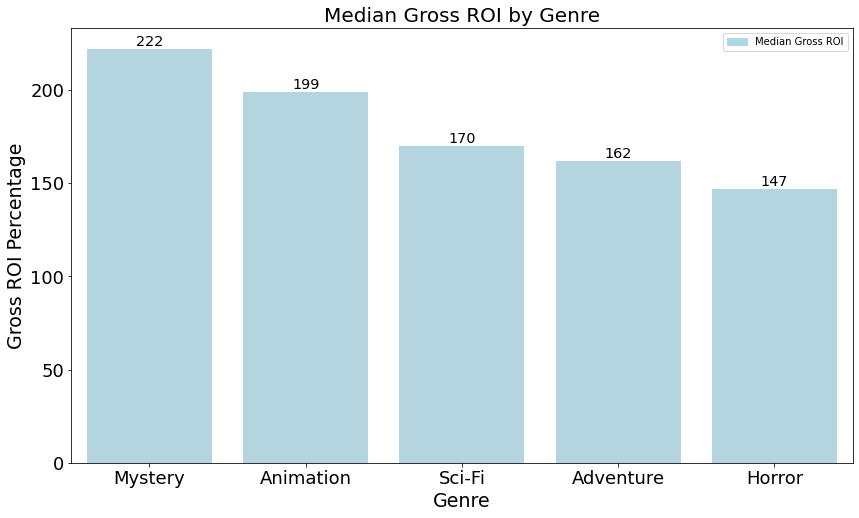

In [3637]:
plt.figure(figsize=(14, 8))

ax1 = sns.barplot(x="genre",  y='gross_roi', data=genre_roi_df, color='lightblue')


# add legend
bar = mpatches.Patch(color='lightblue', label='Median Gross ROI')
plt.legend(handles=[bar])

for index, row in genre_roi_df.iterrows():
    ax1.text(row.name, row['gross_roi'], row['gross_roi'], color='black', ha="center",
             fontsize='x-large',va='bottom')

# show the graph
plt.title("Median Gross ROI by Genre",fontsize=20)
plt.xlabel('Genre',fontsize=19)
plt.ylabel('Gross ROI Percentage',fontsize=19)
plt.tick_params(axis='x',labelsize=18)
plt.tick_params(axis='y',labelsize=18)
plt.show()


#Used stackoverflow example to see how to do the labeling on the bar graph as well as the legend.
#(https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot)
#(https://stackoverflow.com/questions/65272126/seaborn-how-to-add-legend-to-seaborn-barplot)

In [3638]:
month_df = combined_df[['movie', 'gross_roi', 'month']]

In [3639]:
month_df = month_df.drop_duplicates()

In [3640]:
month_roi_df = month_df.groupby('month')[['gross_roi']].median().reset_index()

In [3641]:
month_roi_df = month_roi_df[['month','gross_roi']].sort_values(by='gross_roi',ascending=False).reset_index(
                                                                                                drop=True).head()

In [3642]:
month_roi_df['gross_roi'] = month_roi_df['gross_roi'].apply(lambda x: round(x))

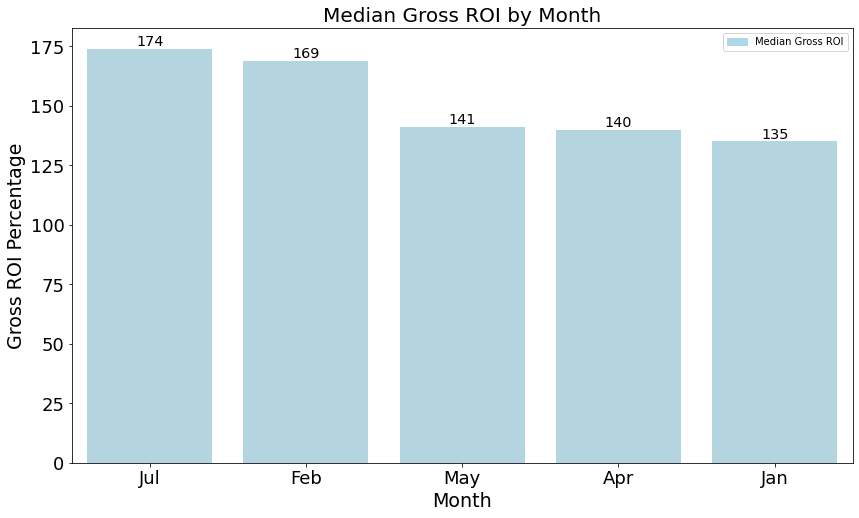

In [3643]:
plt.figure(figsize=(14, 8))

ax1 = sns.barplot(x="month",  y='gross_roi', data=month_roi_df, color='lightblue')


# add legend
bar = mpatches.Patch(color='lightblue', label='Median Gross ROI')
plt.legend(handles=[bar])

for index, row in month_roi_df.iterrows():
    ax1.text(row.name, row['gross_roi'], row['gross_roi'], color='black', ha="center",
             fontsize='x-large',va='bottom')

# show the graph
plt.title("Median Gross ROI by Month",fontsize=20)
plt.xlabel('Month',fontsize=19)
plt.ylabel('Gross ROI Percentage',fontsize=19)
plt.tick_params(axis='x',labelsize=18)
plt.tick_params(axis='y',labelsize=18)
plt.show()


#Used stackoverflow example to see how to do the labeling on the bar graph as well as the legend.
#(https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot)
#(https://stackoverflow.com/questions/65272126/seaborn-how-to-add-legend-to-seaborn-barplot)

In [3644]:
director_roi_df = combined_df[['movie','primary_name','gross_roi']]

In [3645]:
director_roi_df = director_roi_df.groupby('primary_name')[['gross_roi', 'movie']].agg({'gross_roi':'median',
                                                                                       'movie':'count'}).
                                                                                        sort_values(by='gross_roi',
                                                                                        ascending=False)

In [3647]:
director_roi_df = director_roi_df[director_roi_df['movie']>=5].head(10).reset_index()

In [3648]:
director_roi_df['gross_roi'] = director_roi_df['gross_roi'].apply(lambda x: round(x))

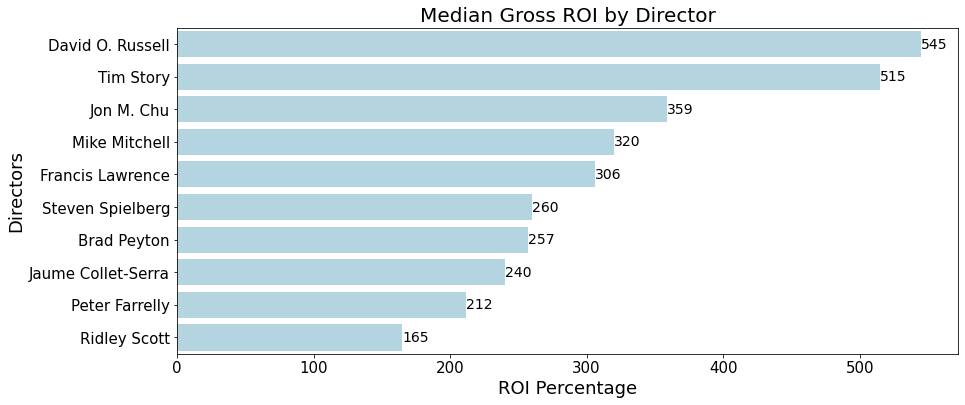

In [3649]:
plt.figure(figsize=(14, 6))

ax1 = sns.barplot(x="gross_roi",  y='primary_name', data=director_roi_df, color='lightblue')

ax1.bar_label(ax1.containers[0],size=14)
# show the graph

plt.title('Median Gross ROI by Director',fontsize=20)
plt.xlabel('ROI Percentage',fontsize=18)
plt.ylabel('Directors',fontsize=18)
plt.tick_params(axis='y',labelsize=15)
plt.tick_params(axis='x',labelsize=15)
plt.show()

#Another way to do bar label that i learned about on stackoverflow.
#(https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn)

# Exploratory Analysis

# Conclusions

## Limitations

## Recommendations

## Next Steps